In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

TypeError: 'NoneType' object is not subscriptable

In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return " ".join([w for w in text.split() if w not in stop_words])

train["comment_text"] = train["comment_text"].astype(str).apply(clean_text)
test["comment_text"] = test["comment_text"].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
max_words = 100000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train["comment_text"])

X = tokenizer.texts_to_sequences(train["comment_text"])
X = pad_sequences(X, maxlen=max_len, padding="post", truncating="post")

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[label_cols].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.models import Sequential

embedding_dim = 128

model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Conv1D(128, kernel_size=5, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_cols), activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 150, 128)       │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 146, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 146, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 146, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 144, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,087,750 (53.74 MB)

 Trainable params: 14,087,494 (53.74 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True
)

history = model.fit(
    X_train, y_train,
    epochs=6,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 562s 996ms/step - accuracy: 0.7494 - loss: 0.1183 - val_accuracy: 0.9940 - val_loss: 0.0744
Epoch 2/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 556s 987ms/step - accuracy: 0.9736 - loss: 0.0504 - val_accuracy: 0.9940 - val_loss: 0.0559
Epoch 3/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 536s 955ms/step - accuracy: 0.9810 - loss: 0.0424 - val_accuracy: 0.9804 - val_loss: 0.0592
Epoch 4/6
561/561 ━━━━━━━━━━━━━━━━━━━━ 579s 986ms/step - accuracy: 0.9339 - loss: 0.0378 - val_accuracy: 0.8388 - val_loss: 0.0660


In [16]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

print("Macro F1-score:", f1_score(y_val, y_pred, average='macro'))
print("\nAccuracy:", accuracy_score(y_val.flatten(), y_pred.flatten()))
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_cols))

499/499 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step
Macro F1-score: 0.44526854507873176

Accuracy: 0.9808768851568701

Detailed Classification Report:
               precision    recall  f1-score   support

        toxic       0.82      0.74      0.77      1480
 severe_toxic       0.46      0.38      0.41       148
      obscene       0.75      0.82      0.79       836
       threat       0.00      0.00      0.00        37
       insult       0.70      0.70      0.70       791
identity_hate       0.00      0.00      0.00       147

    micro avg       0.75      0.69      0.72      3439
    macro avg       0.45      0.44      0.45      3439
 weighted avg       0.71      0.69      0.70      3439
  samples avg       0.06      0.06      0.06      3439



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

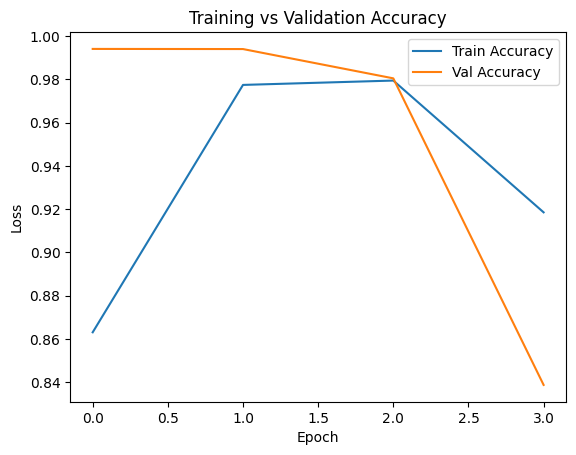

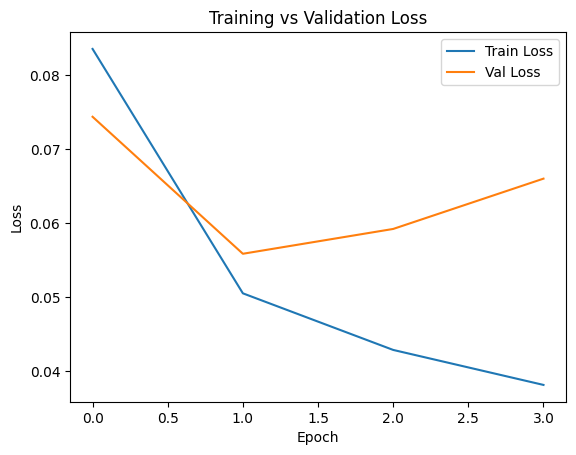

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [18]:
model.save("conv1d_toxic_comment_model.h5")
print("Model saved successfully as conv1d_toxic_comment_model.h5")

Model saved successfully as conv1d_toxic_comment_model.h5


In [ ]:
from nltk.translate.gale_church import align_blocks
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def predict_toxicity_with_labels(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    pred = model.predict(padded)[0]

    output_lines = []
    output_lines.append(f"{'Категория':<20}{'Задетектировано':<25}{'Процент':<10}")
    output_lines.append("-" * 55)
    for label, p in zip(label_cols, pred):
        detected = "Да" if p > 0.5 else "Нет"
        output_lines.append(f"{label:<20}{detected:<25}{p*100:>6.1f}%")

    return "```\n" + "\n".join(output_lines) + "\n```"

interface = gr.Interface(
    flagging_mode="never",
    fn=predict_toxicity_with_labels,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Ваш текст...",
        label="Впишите сюда текст на английском языке"
    ),
    outputs=gr.Markdown(
        label="Результаты прогнозирования (обнаруженные метки и уверенность)"
    ),
    title="Классификация токсичности комментариев (Conv1D)",
    submit_btn="Отправить",
    clear_btn="Очистить",
    css="""
    .gradio-container {
        max-width: 700px !important;
        margin: 0 auto !important;
    }
    .container {
        text-align: center !important;
    }
    """
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ae4fcf09837b6007e7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
